# ECHAM-SALSA Aerosol Data Introduction

General introduction how the station co-located ECHAM-SALSA data can be read using the online catalog and used for a small cluster analysis.

In [4]:
# general
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import pandas as pd
import os
import intake
# dask
import dask
import dask.array as da
from dask.distributed import Client
# statistics
import scipy.cluster.hierarchy as sch
from scipy.spatial.distance import pdist, squareform


Since we are working with large datasets, we use [Dask](https://metos-uio.github.io/eScience2025/learning/notebooks/dask_intro/) to avoid overloading the memory.

In [5]:
client = Client()
client

/opt/conda/envs/pangeo-notebook/lib/python3.11/site-packages/distributed/node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 41461 instead
  warnings.warn(


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /user/fc%3Auid%3Ac001c18e-88e2-449d-be62-663893db7f63/proxy/41461/status,
Dashboard: /user/fc%3Auid%3Ac001c18e-88e2-449d-be62-663893db7f63/proxy/41461/status,Workers: 4
Total threads: 16,Total memory: 16.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:40099,Workers: 4
Dashboard: /user/fc%3Auid%3Ac001c18e-88e2-449d-be62-663893db7f63/proxy/41461/status,Total threads: 16
Started: Just now,Total memory: 16.00 GiB
Comm: tcp://127.0.0.1:40965,Total threads: 4
Dashboard: /user/fc%3Auid%3Ac001c18e-88e2-449d-be62-663893db7f63/proxy/35191/status,Memory: 4.00 GiB
Nanny: tcp://127.0.0.1:41991,


In [ ]:
path = ('/mnt/craas2-ns9988k/data/catalogs/')
filename = os.path.join(path, 'salsa_catalog.json')
col = intake.open_esm_datastore(filename)

In [8]:
col

,unique
bin_index,10
variable,93
species,7
bin,17
category,2
soluble,2
unit,3
long_name,93
start_time,96
end_time,96


This provides an overview of what kind of data we are dealing with. For example there are two unique values for the attribute "soluble", since it can only be either True or False. The bins are sorted into insoluble and soluble bins.

#### SALSA aerosol bin structure

| Bin | bin_index | Species | Soluble | Center diameter (nm) | Upper bound | Lower bound |
| :---: | :---: | :---: | :---: | :---: | :---: | :---: |
| 1a1 | i1 | H2SO4, OC | True | 4.79 | 3.0 | 7.66 |
| 1a2 | i2 | H2SO4, OC  | True | 12.2 | 7.66 | 19.6 |
| 1a3 | i3 | H2SO4, OC  | True | 31.3 | 19.6 | 50.0 |
| 2a1 | i4 | H2SO4, DU, OC, SS, BC | True | 69.5 | 50.0 | 96.7 |
| 2a2 | i5 | H2SO4, DU, OC, SS, BC  | True | 135.0 | 96.7 | 187.0 |
| 2a3 | i6 | H2SO4, DU, OC, SS, BC  | True | 260.0 | 187.0 | 362.0 |
| 2a4 | i7 | H2SO4, DU, OC, SS, BC  | True | 503.0 | 362.0 | 700.0 |
| 2a5 | i8 | H2SO4, DU, OC, SS, BC  | True | 1090.0 | 700.0 | 1700.0 |
| 2a6 | i9 | H2SO4, DU, OC, SS, BC  | True | 2650.0 | 1700.0 | 4120.0 |
| 2a7 | i10 | H2SO4, DU, OC, SS, BC  | True | 6420.0 | 4120.0 | 10000.0 |
| 2b1 | i4 | H2SO4, DU, OC, BC  | False | 69.5 | 50.0 | 96.7 |
| 2b2 | i5 | H2SO4, DU, OC, BC  | False | 135.0 | 96.7 | 187.0 |
| 2b3 | i6 | H2SO4, DU, OC, BC  | False | 260.0 | 187.0 | 362.0 |
| 2b4 | i7 | H2SO4, DU, OC, BC  | False | 503.0 | 362.0 | 700.0 |
| 2b5 | i8 | H2SO4, DU, OC, BC  | False | 1090.0 | 700.0 | 1700.0 |
| 2b6 | i9 | H2SO4, DU, OC, BC  | False | 2650.0 | 1700.0 | 4120.0 |
| 2b7 | i10 | H2SO4, DU, OC, BC | False | 6420.0 | 4120.0 | 10000.0 |

H2SO4 is sulfate aerosol, DU is mineral dust, OC is organic carbon, and SS is sea spray.
There are three size groups for aerosol in ECHAM-SALSA. 1a: The smallest bin range, only contains Sulfate and is considered soluble. 2a: The larger soluble range, which contains all aerosol species. 2b: The larger insoluble range, which also contains all aerosols. The bin index is the same for the soluble/insoluble bins in the larger range.

NOTE: The bin_index attribute is not an official naming. If you use this for plotting later, it might be worth using radii or the original bin names instead. 

#### Data subsets
Select for a specific time period or species with _search_. To check out, what species are available, we can use _.unique()_.

In [9]:
col.df['species'].unique()


array(['bc', 'conccn', 'du', 'h2so4', 'mmrtr', 'oc', 'ss'], dtype=object)

In [ ]:
cat = col.search(species=['bc','du','ss','h2so4','oc'], #, now we get only the mass mixing ratios for all species
                 vertical_coord='pressure' # or 'hybrid' if you feel fancy prs is up to ~200hPa
                #start_time=["2012-01-01"],
				#bin_index= ["i1"],
				#variable = ["h2so4_1a1"],
				#bin = ["1a1"],
				#soluble = [True'],
				#unit = ['kg/kg']
                )
cat

,unique
bin_index,10
variable,45
species,4
bin,17
category,1
soluble,2
unit,1
long_name,45
start_time,96
end_time,96


In [11]:
cat.df['species'].unique()

array(['du', 'h2so4', 'oc', 'ss'], dtype=object)

#### Create a dictionary
Now we can create a dictionary of the datasets we have selected. This will automatically aggregate the selected time steps. For this step, you usually need Dask (activated above) and it might take a couple of minutes, depending on how much data you have selected.

In [12]:
dset_dict = cat.to_dataset_dict()


--> The keys in the returned dictionary of datasets are constructed as follows:
	'bin_index'


/opt/conda/envs/pangeo-notebook/lib/python3.11/site-packages/intake_esm/core.py:253: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  records = grouped.get_group(internal_key).to_dict(orient='records')
/opt/conda/envs/pangeo-notebook/lib/python3.11/site-packages/intake_esm/core.py:253: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  records = grouped.get_group(internal_key).to_dict(orient='records')
/opt/conda/envs/pangeo-notebook/lib/python3.11/site-packages/intake_esm/core.py:253: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  records = gr

The keys for the dictionary are the bin_index values. We can adapt this if a different data structure is more useful for your analysis (e.g. have the bins as keys instead of the bin_index). You may want to convert from hybrid coordinates to pressure coordinates. Information on how this is done is in the [documentation](https://metos-uio.github.io/eScience2025/learning/notebooks/interpolate_hybridsigma2pressure_coords/).

In [14]:
dset_dict['i1'] # check out the smallest bin

<xarray.Dataset> Size: 66MB
Dimensions:    (time: 23376, ncells: 15, lev: 47, nhyi: 48, nhym: 47)
Coordinates:
  * time       (time) datetime64[ns] 187kB 2012-01-01T02:52:30 ... 2019-12-31...
    lon        (ncells) float64 120B dask.array<chunksize=(15,), meta=np.ndarray>
    lat        (ncells) float64 120B dask.array<chunksize=(15,), meta=np.ndarray>
  * lev        (lev) float64 376B 1.0 2.0 3.0 4.0 5.0 ... 44.0 45.0 46.0 47.0
    hyai       (nhyi) float64 384B dask.array<chunksize=(48,), meta=np.ndarray>
    hybi       (nhyi) float64 384B dask.array<chunksize=(48,), meta=np.ndarray>
    hyam       (nhym) float64 376B dask.array<chunksize=(47,), meta=np.ndarray>
    hybm       (nhym) float64 376B dask.array<chunksize=(47,), meta=np.ndarray>
Dimensions without coordinates: ncells, nhyi, nhym
Data variables:
    h2so4_1a1  (time, lev, ncells) float32 66MB dask.array<chunksize=(248, 47, 15), meta=np.ndarray>
Attributes: (12/24)
    CDI:                               Climate Data Interface version 2.0.5 (...
    Conventions:                       CF-1.4
    title:                             SALSA_GlobalTraj-PRECIP
    echam_version:                     6.3.02
    advection:                         Lin & Rood
    physics:                           Modified ECMWF physics
    ...                                ...
    intake_esm_attrs:soluble:          True
    intake_esm_attrs:unit:             kg/kg
    intake_esm_attrs:long_name:        sulfuric acid 1a1
    intake_esm_attrs:vertical_levels:  47
    intake_esm_attrs:_data_format_:    netcdf
    intake_esm_dataset_key:            i1

#### Station names
The data we have is collocated with measuring stations. Currently the dimension ncells describes the lat-lon location. We can replace this with the actual station names.

In [20]:
# read the csv with station information
station_file = pd.read_csv('/mnt/craas2-ns9988k-dl-ns9560k/chrisvbr/ECHAM-SALSA-data/locations.csv', delimiter = ',', index_col=0)

names = np.array(station_file.columns)

# replace ncells with station names
for key in dset_dict.keys():
    dset_dict[key] = dset_dict[key].rename({'ncells': 'station'}).reset_coords(drop=True)
    dset_dict[key]['station'] = ('station', names)
dset_dict['i1'].station

<xarray.DataArray 'station' (station: 15)> Size: 120B
array(['ZEP', 'SMR-II', 'ATTO', 'MHD', 'SGP', 'CHC', 'BIR-II', 'PAL',
       'Vavihill', 'JFJ', 'FKL', 'SMEAR-I', 'Villum', 'Izana', 'Maldives'],
      dtype=object)
Coordinates:
  * station  (station) object 120B 'ZEP' 'SMR-II' 'ATTO' ... 'Izana' 'Maldives'

To get an overview of the stations:

In [21]:
station_file

,ZEP,SMR-II,ATTO,MHD,SGP,CHC,BIR-II,PAL,Vavihill,JFJ,FKL,SMEAR-I,Villum,Izana,Maldives
,,,,,,,,,,,,,,,
lon,11.89,24.28,-59.0,-9.9,-97.485,-68.13,8.25,24.12,13.15,7.98,25.67,29.6,-16.67,-16.4994,73.183049
lat,78.91,61.85,-2.143,53.33,36.605,-16.35,58.39,67.97,56.02,46.55,35.34,67.75,81.6,28.309,6.77648
grid_nr_echam,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
nice_name,Zeppelin,SMEAR-II,ATTO,Mace Head,Southern Great Plains,Chacaltaya,Birkenes-II,Pallas,Vavihill,Jungfraujoch,Finokalia,Värriö (SMEAR-I),Villum,Izana,Maldives
lon_str,11.89e,24.28e,59.00w,9.90w,97.48w,68.13w,8.25e,24.12e,13.15e,7.98e,25.67e,29.60e,16.67w,16.50w,73.18e
lat_str,78.91n,61.85n,2.14s,53.33n,36.60n,16.35s,58.39n,67.97n,56.02n,46.55n,35.34n,67.75n,81.60n,28.31n,6.78n
fincl2lonlat,'11.89e_78.91n','24.28e_61.85n','59.00w_2.14s','9.90w_53.33n','97.48w_36.60n','68.13w_16.35s','8.25e_58.39n','24.12e_67.97n','13.15e_56.02n','7.98e_46.55n','25.67e_35.34n','29.60e_67.75n','16.67w_81.60n','16.50w_28.31n','73.18e_6.78n'


#### Example
Here is a simple example what one can do with one station. This is a time average for Zeppelin station (Svalbard) at one height level.

In [24]:
ZEP_mean = {}
for key, dataset in dset_dict.items():
    time_mean = dataset.mean(dim='time')  # Calculate the time mean
    ZEP_mean[key] = time_mean.sel(lev=30, station="ZEP")  # Select level and station
sorted_keys = sorted(ZEP_mean.keys(), key=lambda x: int(x[1:])) # sort by the bins by number (technically not necessary but it is neater)
ZEP_sorted = {key: ZEP_mean[key] for key in sorted_keys}
print('bin_index before sorting:', ZEP_mean.keys())
print('bin_index after sorting', ZEP_sorted.keys())

bin_index before sorting: dict_keys(['i3', 'i1', 'i2', 'i4', 'i10', 'i9', 'i7', 'i8', 'i6', 'i5'])
bin_index after sorting dict_keys(['i1', 'i2', 'i3', 'i4', 'i5', 'i6', 'i7', 'i8', 'i9', 'i10'])


Currently the data is structured as bin.variable, whereas the variablename also incorporates the bin (e.g. "h2so4_1a1), and each dictionary entry is one dataset. 


In [ ]:
for key in ZEP_sorted.keys():
	print('bin_index:', key, list(ZEP_sorted[key].data_vars))


bin_index: i1 ['h2so4_1a1']
bin_index: i2 ['h2so4_1a2']
bin_index: i3 ['h2so4_1a3']
bin_index: i4 ['du_2a1', 'du_2b1', 'h2so4_2a1', 'oc_2a1', 'oc_2b1', 'ss_2a1']
bin_index: i5 ['du_2a2', 'du_2b2', 'h2so4_2a2', 'oc_2a2', 'oc_2b2', 'ss_2a2']
bin_index: i6 ['du_2a3', 'du_2b3', 'h2so4_2a3', 'oc_2a3', 'oc_2b3', 'ss_2a3']
bin_index: i7 ['du_2a4', 'du_2b4', 'h2so4_2a4', 'oc_2a4', 'oc_2b4', 'ss_2a4']
bin_index: i8 ['du_2a5', 'du_2b5', 'h2so4_2a5', 'oc_2a5', 'oc_2b5', 'ss_2a5']
bin_index: i9 ['du_2a6', 'du_2b6', 'h2so4_2a6', 'oc_2a6', 'oc_2b6', 'ss_2a6']
bin_index: i10 ['du_2a7', 'du_2b7', 'h2so4_2a7', 'oc_2a7', 'oc_2b7', 'ss_2a7']


Due to the averaging, we now ended up with a single value per variable in each dataset in the dictionary. This is an attempt to make a nicer representation in the form of a table wit bins as rows and species as columns.

In [26]:
species_names = ['du_a', 'du_b', 'h2so4_a', 'oc_a', 'oc_b', 'ss_a'] # a for soluble, b for insoluble, consider changing this to du and du_insoluble
for key in ZEP_sorted.keys():
    varnames = list(ZEP_sorted[key].data_vars)
    species = [
        (s[:-3] + s[-2:-1])
        for s in varnames
		]
    rename_map = dict(zip(varnames, species))
    ZEP_sorted[key] = ZEP_sorted[key].rename(rename_map)
    for i in species_names:
        if i not in species:
            ZEP_sorted[key][i] = np.array(0.)
    print(species)


['h2so4_a']
['h2so4_a']
['h2so4_a']
['du_a', 'du_b', 'h2so4_a', 'oc_a', 'oc_b', 'ss_a']
['du_a', 'du_b', 'h2so4_a', 'oc_a', 'oc_b', 'ss_a']
['du_a', 'du_b', 'h2so4_a', 'oc_a', 'oc_b', 'ss_a']
['du_a', 'du_b', 'h2so4_a', 'oc_a', 'oc_b', 'ss_a']
['du_a', 'du_b', 'h2so4_a', 'oc_a', 'oc_b', 'ss_a']
['du_a', 'du_b', 'h2so4_a', 'oc_a', 'oc_b', 'ss_a']
['du_a', 'du_b', 'h2so4_a', 'oc_a', 'oc_b', 'ss_a']


In [27]:
data = []
# Get values from each bin/variable
for bin_key in ZEP_sorted.keys():
    bin_values = {var_key: ZEP_sorted[bin_key][var_key].values.tolist() for var_key in ZEP_sorted[bin_key].keys()}

    # Add the bin values along with the bin key to the data list
    data.append({'bin_index': bin_key, **bin_values})

df = pd.DataFrame(data)
df.set_index('bin_index', inplace=True)
print(df)


                h2so4_a          du_a          du_b          oc_a  \
bin_index                                                           
i1         1.325061e-14  0.000000e+00  0.000000e+00  0.000000e+00   
i2         1.784687e-13  0.000000e+00  0.000000e+00  0.000000e+00   
i3         4.289806e-12  0.000000e+00  0.000000e+00  0.000000e+00   
i4         1.623046e-11  1.734552e-16  3.983981e-17  5.243597e-13   
i5         5.285494e-11  7.083557e-14  9.193136e-13  7.713593e-12   
i6         1.458554e-10  7.269574e-13  2.182388e-11  3.534453e-11   
i7         8.502354e-11  3.762841e-13  5.071292e-11  1.152995e-11   
i8         2.467885e-11  9.475300e-14  6.709647e-10  1.032573e-12   
i9         2.045511e-12  1.502657e-14  1.520320e-09  1.903570e-13   
i10        4.482060e-13  8.427441e-15  4.398044e-10  1.699937e-13   

                   oc_b          ss_a  
bin_index                              
i1         0.000000e+00  0.000000e+00  
i2         0.000000e+00  0.000000e+00  
i3         

#### Visualization
Now we can finally plot the data to get an idea of the distribution of aerosol species. Here is an example with normalized values.

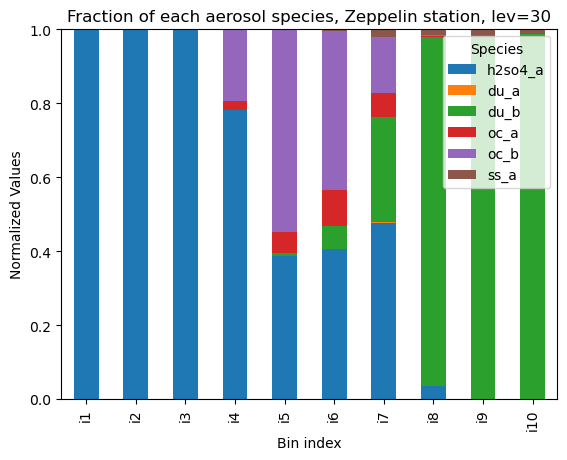

In [28]:
# Normalize the transposed DataFrame so that each category sums up to 1
df_normalized = df.div(df.sum(axis=1), axis=0)

# Create a stacked bar plot with categories on the x-axis
ax = df_normalized.plot(kind='bar', stacked=True)
plt.title("Fraction of each aerosol species, Zeppelin station, lev=30")
plt.xlabel("Bin index")
plt.ylabel("Normalized Values")
plt.legend(title="Species", loc='upper right')
plt.ylim(0, 1)
plt.show()

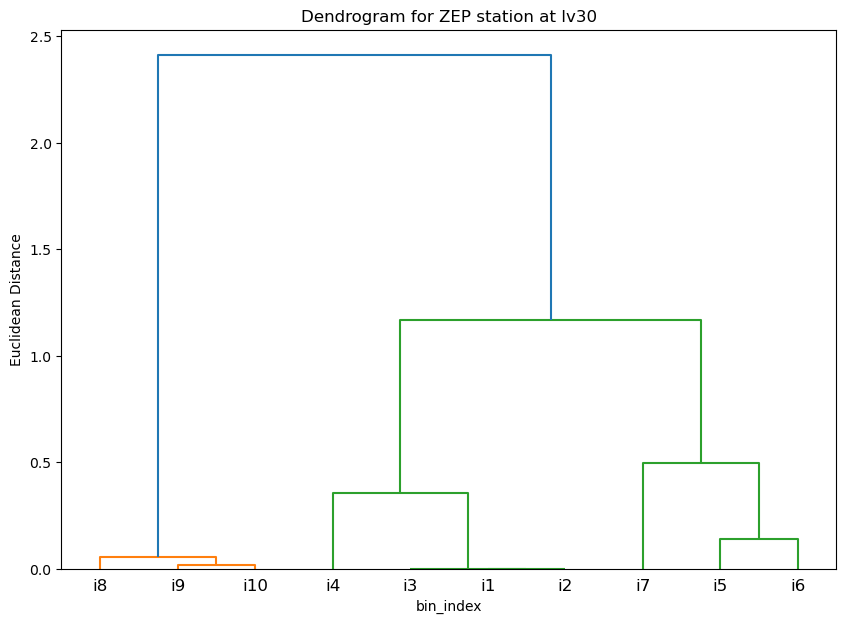

In [29]:

# Example data: 10 bins with 3 features
bins = df_normalized.index

# Calculate the distance matrix
distance_matrix = pdist(df_normalized, metric='euclidean')
dendrogram = sch.linkage(distance_matrix, method='ward')  # You can choose other methods like 'single', 'complete', etc.
# Create the hierarchical clustering
# Using the ward method is common for minimizing variance
linkage_matrix = sch.linkage(distance_matrix, method='ward')

plt.figure(figsize=(10, 7))
dendrogram = sch.dendrogram(linkage_matrix, labels=bins)
plt.title('Dendrogram for ZEP station at lv30')
plt.xlabel('bin_index')
plt.ylabel('Euclidean Distance')
plt.show()
